In [75]:
#7/10-7/11
#モジュールインポート
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import numba
from numba.decorators import jit

## データ：Haskell法により作成 

In [171]:
class Haskell: #上から順に実行すれば必要な変数は計算できます。
    
    #def　__init__(self):
        
    def basic_parameters(nt,rayer_num,dt=0.01): # (層構造による基本パラメータ) 弄る事はあまりない
        '''
        t:サンプリング数→時間
        dt:サンプリング間隔[s] 
        rayer_num:層構造の数
        '''
        time_window=nt*dt # 見たい時間長[s]
        t = np.arange(0, time_window, dt) # 時間軸に変更→後のプロット用
        freq = np.linspace(0.0000001, 0.5/dt, nt/2+1) # 周波数軸 基本は0〜50[Hz](50+1)
        ω=2*np.pi*freq # 角周波数
        
        if rayer_num==2:
            H=[2,8]
            Vp=[1,1]
            Vs=[0.5,0.5]
            
        if rayer_num==8:
            H=[0.025,0.050,0.175,0.30,0.45,0.5,0.5,1.2]
            Vp=[0.72,1.19,1.67,1.8,2.04,2.16,2.33,3.2]
            Vs=[0.24,0.34,0.44,0.54,0.77,0.94,1.07,1.8]
        
        return nt,dt,time_window,rayer_num,t,ω,H,Vp,Vs
        
    #@numba.jit
    def haskell_matrix(θ_in,rayer_num,wave_type):  # haskell計算に必要な行列の作成 変えながら計算する
        '''
        θ_in:入射角
        wave_type:P波orS波
        rayer_num
        '''
        ρ=[]
        μ=[]
        sinθp,sinθs=[],[]
        cosθp,cosθs=[],[]
        ν,γ=[],[]
        η,ξ=[],[]
        
        θ_in=θ_in/360*2*np.pi #radianに変換 
        
        if wave_type=='P':
            k=ω*np.sin(θ_in)/Vp[-1]
            p=k/ω #水平スローネスは一定
            for i in range(rayer_num):
                ρ_i=(Vp[i]+1.87)/2.87
                μ_i=ρ_i*Vs[i]**2
                sinθp_i,sinθs_i=Vp[i]/Vp[-1]*np.sin(θ_in),Vs[i]/Vp[-1]*np.sin(θ_in)
                cosθp_i,cosθs_i=np.sqrt(1-sinθp_i**2),np.sqrt(1-sinθs_i**2)
                ν_i,γ_i=ω*cosθp_i/Vp[i],ω*cosθs_i/Vs[i]
                η_i,ξ_i=γ_i/ω,ν_i/ω
                ρ.append(ρ_i)
                μ.append(μ_i)
                sinθp.append(sinθp_i),sinθs.append(sinθs_i)
                cosθp.append(cosθp_i),cosθs.append(cosθs_i)
                ν.append(ν_i),γ.append(γ_i)
                η.append(η_i),ξ.append(ξ_i)

        if wave_type=='S':
            k=ω*np.sin(θ_in)/Vs[-1]
            p=k/ω #水平スローネスは一定
            for i in range(rayer_num):
                ρ_i=(Vp[i]+1.87)/2.87
                μ_i=ρ_i*Vs[i]**2
                sinθp_i,sinθs_i=Vp[i]/Vs[-1]*np.sin(θ_in),Vs[i]/Vs[-1]*np.sin(θ_in)
                cosθp_i,cosθs_i=np.sqrt(1-sinθp_i**2),np.sqrt(1-sinθs_i**2)
                ν_i,γ_i=ω*cosθp_i/Vp[i],ω*cosθs_i/Vs[i]
                η_i,ξ_i=γ_i/ω,ν_i/ω    
                ρ.append(ρ_i)
                μ.append(μ_i)
                sinθp.append(sinθp_i),sinθs.append(sinθs_i)
                cosθp.append(cosθp_i),cosθs.append(cosθs_i)
                ν.append(ν_i),γ.append(γ_i)
                η.append(η_i),ξ.append(ξ_i)
            
        ZERO=np.zeros(int(nt/2)+1) # 0ではダメ
        E=[]
        invE=[]
        Λ=[]
        for i in range(rayer_num):
            E_i=np.array([[Vp[i]*p,Vs[i]*η[i],Vp[i]*p,Vs[i]*η[i]],
                          [Vp[i]*ξ[i],-Vs[i]*p,-Vp[i]*ξ[i],Vs[i]*p],
                          [2j*ω*ρ[i]*Vp[i]*(Vs[i]**2)*p*ξ[i],1j*ω*ρ[i]*Vs[i]*(1-2*(Vs[i]**2)*(p**2)),-2j*ω*ρ[i]*Vp[i]*(Vs[i]**2)*p*ξ[i],-1j*ω*ρ[i]*Vs[i]*(1-2*(Vs[i]**2)*(p**2))],
                          [1j*ω*ρ[i]*Vp[i]*(1-2*(Vs[i]**2)*(p**2)),-2j*ω*ρ[i]*(Vs[i]**3)*p*η[i],1j*ω*ρ[i]*Vp[i]*(1-2*(Vs[i]**2)*(p**2)),-2j*ω*ρ[i]*(Vs[i]**3)*p*η[i]]])
            E_i=E_i.transpose(2,0,1) #(4×4×n)→#(n×4×4)へ転置する必要がある。
            invE_i=np.linalg.inv(E_i)

            Λ_i=np.array([[np.exp(1j*ν[i]*H[i]),ZERO,ZERO,ZERO],
                          [ZERO,np.exp(1j*γ[i]*H[i]),ZERO,ZERO],
                          [ZERO,ZERO,np.exp(-1j*ν[i]*H[i]),ZERO],
                          [ZERO,ZERO,ZERO,np.exp(-1j*γ[i]*H[i])]])
            Λ_i=Λ_i.transpose(2,0,1)#転置
            E.append(E_i)
            invE.append(invE_i)
            Λ.append(Λ_i)
        
        if rayer_num==2:
            A=(invE[1]@E[0]@Λ[0])@invE[0]
            B=np.linalg.inv(A)
            D_1=invE[0]
            D_2=(invE[1]@E[0]@Λ[0])@invE[0]
            D=[D_1,D_2]
            
        if rayer_num==8:
            A=(invE[7]@E[6]@Λ[6])@(invE[6]@E[5]@Λ[5])@(invE[5]@E[4]@Λ[4])@(invE[4]@E[3]@Λ[3])@(invE[3]@E[2]@Λ[2])@(invE[2]@E[1]@Λ[1])@(invE[1]@E[0]@Λ[0])@invE[0]
            B=np.linalg.inv(A)
            D_1=invE[0]
            D_2=(invE[1]@E[0]@Λ[0])@invE[0]
            D_3=(invE[2]@E[1]@Λ[1])@(invE[1]@E[0]@Λ[0])@invE[0]
            D_4=(invE[3]@E[2]@Λ[2])@(invE[2]@E[1]@Λ[1])@(invE[1]@E[0]@Λ[0])@invE[0]
            D_5=(invE[4]@E[3]@Λ[3])@(invE[3]@E[2]@Λ[2])@(invE[2]@E[1]@Λ[1])@(invE[1]@E[0]@Λ[0])@invE[0]
            D_6=(invE[5]@E[4]@Λ[4])@(invE[4]@E[3]@Λ[3])@(invE[3]@E[2]@Λ[2])@(invE[2]@E[1]@Λ[1])@(invE[1]@E[0]@Λ[0])@invE[0]
            D_7=(invE[6]@E[5]@Λ[5])@(invE[5]@E[4]@Λ[4])@(invE[4]@E[3]@Λ[3])@(invE[3]@E[2]@Λ[2])@(invE[2]@E[1]@Λ[1])@(invE[1]@E[0]@Λ[0])@invE[0]
            D_8=A
            D=[D_1,D_2,D_3,D_4,D_5,D_6,D_7,D_8]            
        
        C=[]
        for i in range(int(nt/2)+1):
            c31=(B[i,2,3]*B[i,3,0]-B[i,3,3]*B[i,2,0])/(B[i,3,3]*B[i,2,2]-B[i,2,3]*B[i,3,2])
            c32=(B[i,2,3]*B[i,3,1]-B[i,3,3]*B[i,2,1])/(B[i,3,3]*B[i,2,2]-B[i,2,3]*B[i,3,2])
            c41=(B[i,2,2]*B[i,3,0]-B[i,3,2]*B[i,2,0])/(B[i,3,2]*B[i,2,3]-B[i,2,2]*B[i,3,3])
            c42=(B[i,2,2]*B[i,3,1]-B[i,3,2]*B[i,2,1])/(B[i,3,2]*B[i,2,3]-B[i,2,2]*B[i,3,3])
            c=np.array([[1,0],[0,1],[c31,c32],[c41,c42]])
            C.append(c)
            
        return B,C,D,E,ν,γ
    
    #@numba.jit
    def get_displacement(inp_P,inp_SV,z,j,B,C,D,E,ν,γ):
        '''
        inp_P:入力P波
        inp_S:入力S波
        z:j層での深さ[km]
        j:見たい層(上から数えて,1始まり)
        B,C,D,E,ν,γ → Haskell matrix
        '''
        # 高速フーリエ変換
        P_fft=np.fft.fft(inp_P)[0:int(nt/2)+1]
        SV_fft=np.fft.fft(inp_SV)[0:int(nt/2)+1]
        #P_fft=np.ones(int(Nt/2)+1) #デルタ関数(時間領域で時刻0部分)
        #SV_fft=np.ones(int(Nt/2)+1) #デルタ関数(時間領域で時刻0部分)
        Input=np.array([[np.array(P_fft)],[np.array(SV_fft)]])
        Input=Input.transpose(2,0,1)

        #層,深さで変化する行列F(z,j)の作成
        ZERO=np.zeros(int(nt/2)+1)
        F_jz=np.array([[np.exp(1j*ν[j-1]*z),ZERO,ZERO,ZERO],
                       [ZERO,np.exp(1j*γ[j-1]*z),ZERO,ZERO],
                       [ZERO,ZERO,np.exp(-1j*ν[j-1]*z),ZERO],
                       [ZERO,ZERO,ZERO,np.exp(-1j*γ[j-1]*z)]])
        F_jz=F_jz.transpose(2,0,1)

        #a→変位、応力の4成分の計算
        a=E[j-1]@F_jz@D[j-1]@B@C@Input
        a=a.transpose(1,0,2)

        FFT_ux,FFT_uz,FFT_tauxz,FFT_tauzz=a[0],a[1],a[2],a[3]
        FFT_ux,FFT_uz,FFT_tauxz,FFT_tauzz=FFT_ux.reshape(int(nt/2)+1),FFT_uz.reshape(int(nt/2)+1),FFT_tauxz.reshape(int(nt/2)+1),FFT_tauzz.reshape(int(nt/2)+1)

        #マイナス周波数側を作成
        calib_ux,calib_uz,calib_tauxz,calib_tauzz=FFT_ux.conjugate()[1:int(nt/2)],FFT_uz.conjugate()[1:int(nt/2)],FFT_tauxz.conjugate()[1:int(nt/2)],FFT_tauzz.conjugate()[1:int(nt/2)]

        fft_ux,fft_uz,fft_tauxz,fft_tauzz=np.zeros(nt,dtype=np.complex),np.zeros(nt,dtype=np.complex),np.zeros(nt,dtype=np.complex),np.zeros(nt,dtype=np.complex)
        #プラス側はそのまま
        fft_ux[0:int(nt/2)+1]=FFT_ux
        fft_uz[0:int(nt/2)+1]=FFT_uz
        fft_tauxz[0:int(nt/2)+1]=FFT_tauxz
        fft_tauzz[0:int(nt/2)+1]=FFT_tauzz
        #マイナス側を補正
        fft_ux[int(nt/2)+1:nt]=calib_ux[::-1]
        fft_uz[int(nt/2)+1:nt]=calib_uz[::-1]
        fft_tauxz[int(nt/2)+1:nt]=calib_tauxz[::-1]
        fft_tauzz[int(nt/2)+1:nt]=calib_tauzz[::-1]

        ux,uz,tauxz,tauzz=np.fft.ifft(fft_ux),np.fft.ifft(fft_uz),np.fft.ifft(fft_tauxz),np.fft.ifft(fft_tauzz)
        return ux,uz#,tauxz,tauzz


    def ricker_wavelet(t,f): #リッカー波 %%!
        '''
        t:時間→位置調整が必要
        f:見たい振動数成分[Hz]
        '''
        a=np.pi*f
        return a/2/np.sqrt(np.pi)*(1-2*a**2*t**2)*np.exp(-a**2*t**2)

### 任意の数の波形を作成する(入射角,周波数,切り出し位置を変化)

In [264]:
#基本パラメータ
nt=2**11
dt=0.01
rayer_num=8
wave_type='P'

T_fundation=np.linspace(-2,time_window-2,nt)#リッカー波の位置の調整
P=Haskell.ricker_wavelet(T_fundation,1)
SV=Haskell.ricker_wavelet(T_fundation,1)
inp_P=P/np.max(P) #規格化
inp_SV=SV/np.max(SV)
#inp_P=np.zeros(nt)
inp_SV=np.zeros(nt)

#基礎パラメータの設定
nt,dt,time_window,rayer_num,t,ω,H,Vp,Vs = Haskell.basic_parameters(nt,rayer_num=rayer_num)

@numba.jit()
def get_Haskell_waveform(n): #n個の波形を作成する
    
    ground_Motion_list=[]
    surface_Motion_list=[]
    

    for i in range(n):
        print(i)
        a=np.random.rand()*5 #位置調整
        f=0.5+3.5*np.random.rand()
        T_fundation=np.linspace(-2-a,time_window-2-a,nt)#リッカー波の位置の調整
        P=Haskell.ricker_wavelet(T_fundation,f)
        SV=Haskell.ricker_wavelet(T_fundation,f)
        inp_P=P/np.max(P) #規格化
        inp_SV=SV/np.max(SV)
        #inp_P=np.zeros(nt)
        inp_SV=np.zeros(nt)
        
        θ_in=45*np.random.rand()
        B,C,D,E,ν,γ=Haskell.haskell_matrix(θ_in=θ_in,rayer_num=rayer_num,wave_type='P')
        
        
        #変位計算
        ux_0m,uz_0m=Haskell.get_displacement(inp_P,inp_SV,0,1,B,C,D,E,ν,γ)
        ux_2000m,uz_2000m=Haskell.get_displacement(inp_P,inp_SV,0,rayer_num,B,C,D,E,ν,γ)

        vz_0m=np.gradient(uz_0m,dt)
        vz_2000m=np.gradient(uz_2000m,dt)

        ground_Motion_list.append(uz_2000m)
        surface_Motion_list.append(uz_0m)

    df=pd.DataFrame({'Ground_Motion':ground_Motion_list,
                     'Surface_Motion':surface_Motion_list})

    return df


%time df=get_Haskell_waveform(1000)

/Users/ishiharamasaya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


/Users/ishiharamasaya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


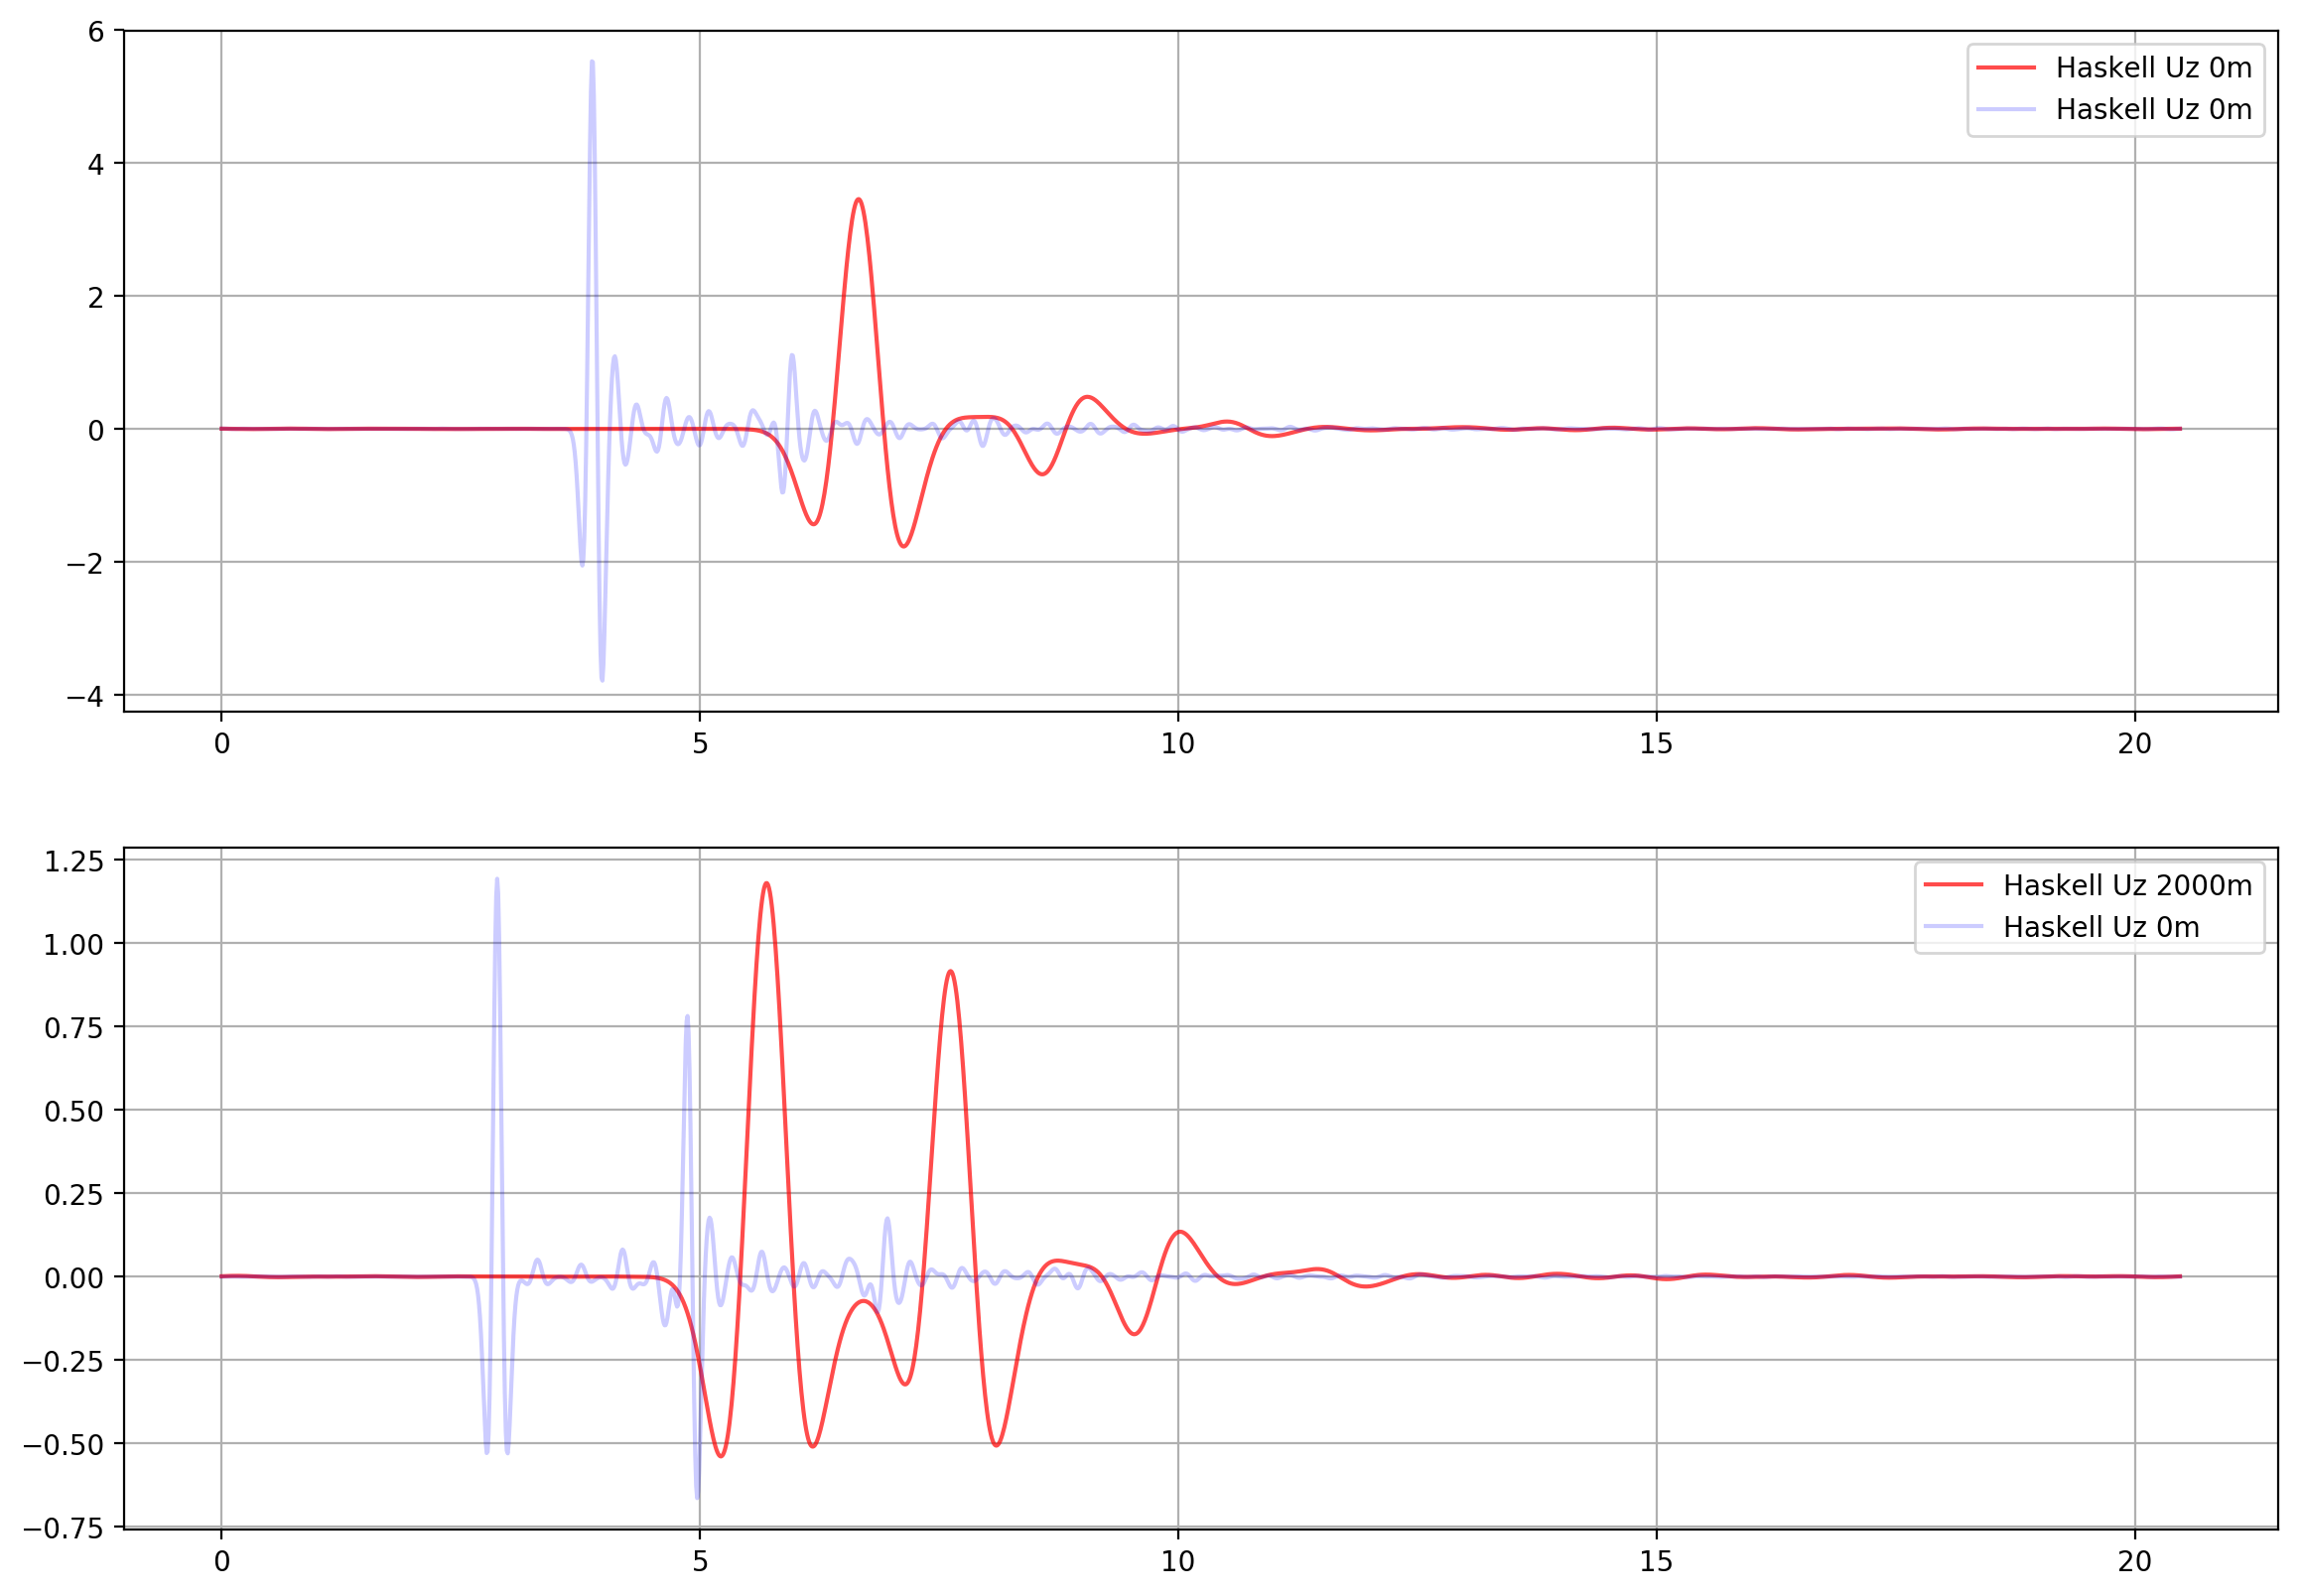

In [258]:
number=5

plt.figure(figsize=(14,10),dpi=200)

plt.subplot(2,1,1)
plt.plot(t,df['Surface_Motion'][number],label='Haskell Uz 0m',c='r',alpha=0.7)
plt.plot(t,df['Surface_Motion'][0],label='Haskell Uz 0m',c='b',alpha=0.2)
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.plot(t,df['Ground_Motion'][number],label='Haskell Uz 2000m',c='r',alpha=0.7)
plt.plot(t,df['Ground_Motion'][0],label='Haskell Uz 0m',c='b',alpha=0.2)
plt.grid()
plt.legend()


In [242]:
#モジュールのインポート
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, BatchNormalization, Add, merge, Flatten
from keras import optimizers
from keras.layers import Input, MaxPooling1D, UpSampling1D, Conv1D,AveragePooling1D
from sklearn.model_selection import train_test_split

### モデルの記述

#### CNN3枚(圧縮なし)→FCNN1枚

In [243]:
input_waveform = Input(shape=(len(t),1)) #計算しやすい形状に調整しいている. X,yも整形しよう

x = Conv1D(16, 3, activation='tanh', border_mode='same')(input_waveform)
#x = BatchNormalization()(x)
x = AveragePooling1D(2, border_mode='same')(x)
#x = BatchNormalization()(x)
x = Conv1D(32,3, activation='tanh', border_mode='same')(x)
#x = BatchNormalization()(x)
x = AveragePooling1D(2, border_mode='same')(x)
#x = BatchNormalization()(x)
x = Conv1D(64, 3, activation='tanh', border_mode='same')(x)
#x = BatchNormalization()(x)
x = AveragePooling1D(2, border_mode='same')(x)

x = Flatten()(x)
x = Dense(128,activation='tanh')(x)
x_output = Dense(len(t),activation='tanh')(x)

simple_CNN=Model(input_waveform, x_output)
simple_CNN.compile(optimizer='adam', loss='mse')

simple_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2048, 1)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 2048, 16)          64        
_________________________________________________________________
average_pooling1d_13 (Averag (None, 1024, 16)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1024, 32)          1568      
_________________________________________________________________
average_pooling1d_14 (Averag (None, 512, 32)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 512, 64)           6208      
_________________________________________________________________
average_pooling1d_15 (Averag (None, 256, 64)           0         
__________

/Users/ishiharamasaya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(16, 3, activation="tanh", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ishiharamasaya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same")`
  """
/Users/ishiharamasaya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(32, 3, activation="tanh", padding="same")`
  import sys
/Users/ishiharamasaya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same")`
  if __name__ == '__main__':
/Users/i

In [265]:
X=np.zeros((len(df),len(t)))
y=np.zeros((len(df),len(t)))
for i in range(len(df)):
    g_waveform=df['Ground_Motion'][i]
    s_waveform=df['Surface_Motion'][i]
    
    #複素数→パワーに変換(学習させるのは画像だから)
    X[i]=g_waveform/np.abs(s_waveform).max()
    y[i]=s_waveform/np.abs(s_waveform).max()

/Users/ishiharamasaya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  
/Users/ishiharamasaya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


In [266]:
#trainingとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train= np.reshape(X_train, (-1, len(t),1))
X_test = np.reshape(X_test, (-1, len(t),1))

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
#y_train= np.reshape(y_train, (-1,len(time),1))
#y_test = np.reshape(y_test, (-1,len(time),1))

print("train data: {0} \ntest data: {1}".format(X_train.shape, X_test.shape))

train data: (2400, 2048, 1) 
test data: (600, 2048, 1)


Train on 2400 samples, validate on 600 samples
Epoch 1/10
  64/2400 [..............................] - ETA: 4s - loss: 9.9228e-04

/Users/ishiharamasaya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


2400/2400 [==============================] - 4s - loss: 9.9191e-04 - val_loss: 9.1722e-04
Epoch 2/10
2400/2400 [==============================] - 5s - loss: 8.8530e-04 - val_loss: 8.6543e-04
Epoch 3/10
2400/2400 [==============================] - 5s - loss: 8.3193e-04 - val_loss: 8.3602e-04
Epoch 4/10
2400/2400 [==============================] - 5s - loss: 7.8466e-04 - val_loss: 7.9267e-04
Epoch 5/10
2400/2400 [==============================] - 5s - loss: 7.4511e-04 - val_loss: 7.7920e-04
Epoch 6/10
2400/2400 [==============================] - 5s - loss: 7.2328e-04 - val_loss: 7.5651e-04
Epoch 7/10
2400/2400 [==============================] - 5s - loss: 7.0872e-04 - val_loss: 7.6295e-04
Epoch 8/10
2400/2400 [==============================] - 5s - loss: 6.8224e-04 - val_loss: 7.3588e-04
Epoch 9/10
2400/2400 [==============================] - 5s - loss: 6.6764e-04 - val_loss: 7.2210e-04
Epoch 10/10
2400/2400 [==============================] - 5s - loss: 6.5563e-04 - val_loss: 7.1952e-04


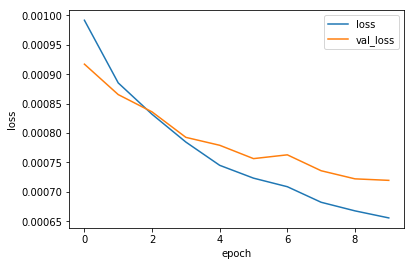

In [267]:
#モデルの学習
epochs=10

history=simple_CNN.fit(X_train, y_train,
                       nb_epoch=epochs,
                       batch_size=2**6,
                       shuffle=True,
                       validation_data=(X_test, y_test),callbacks=[])

plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend() 
plt.show()

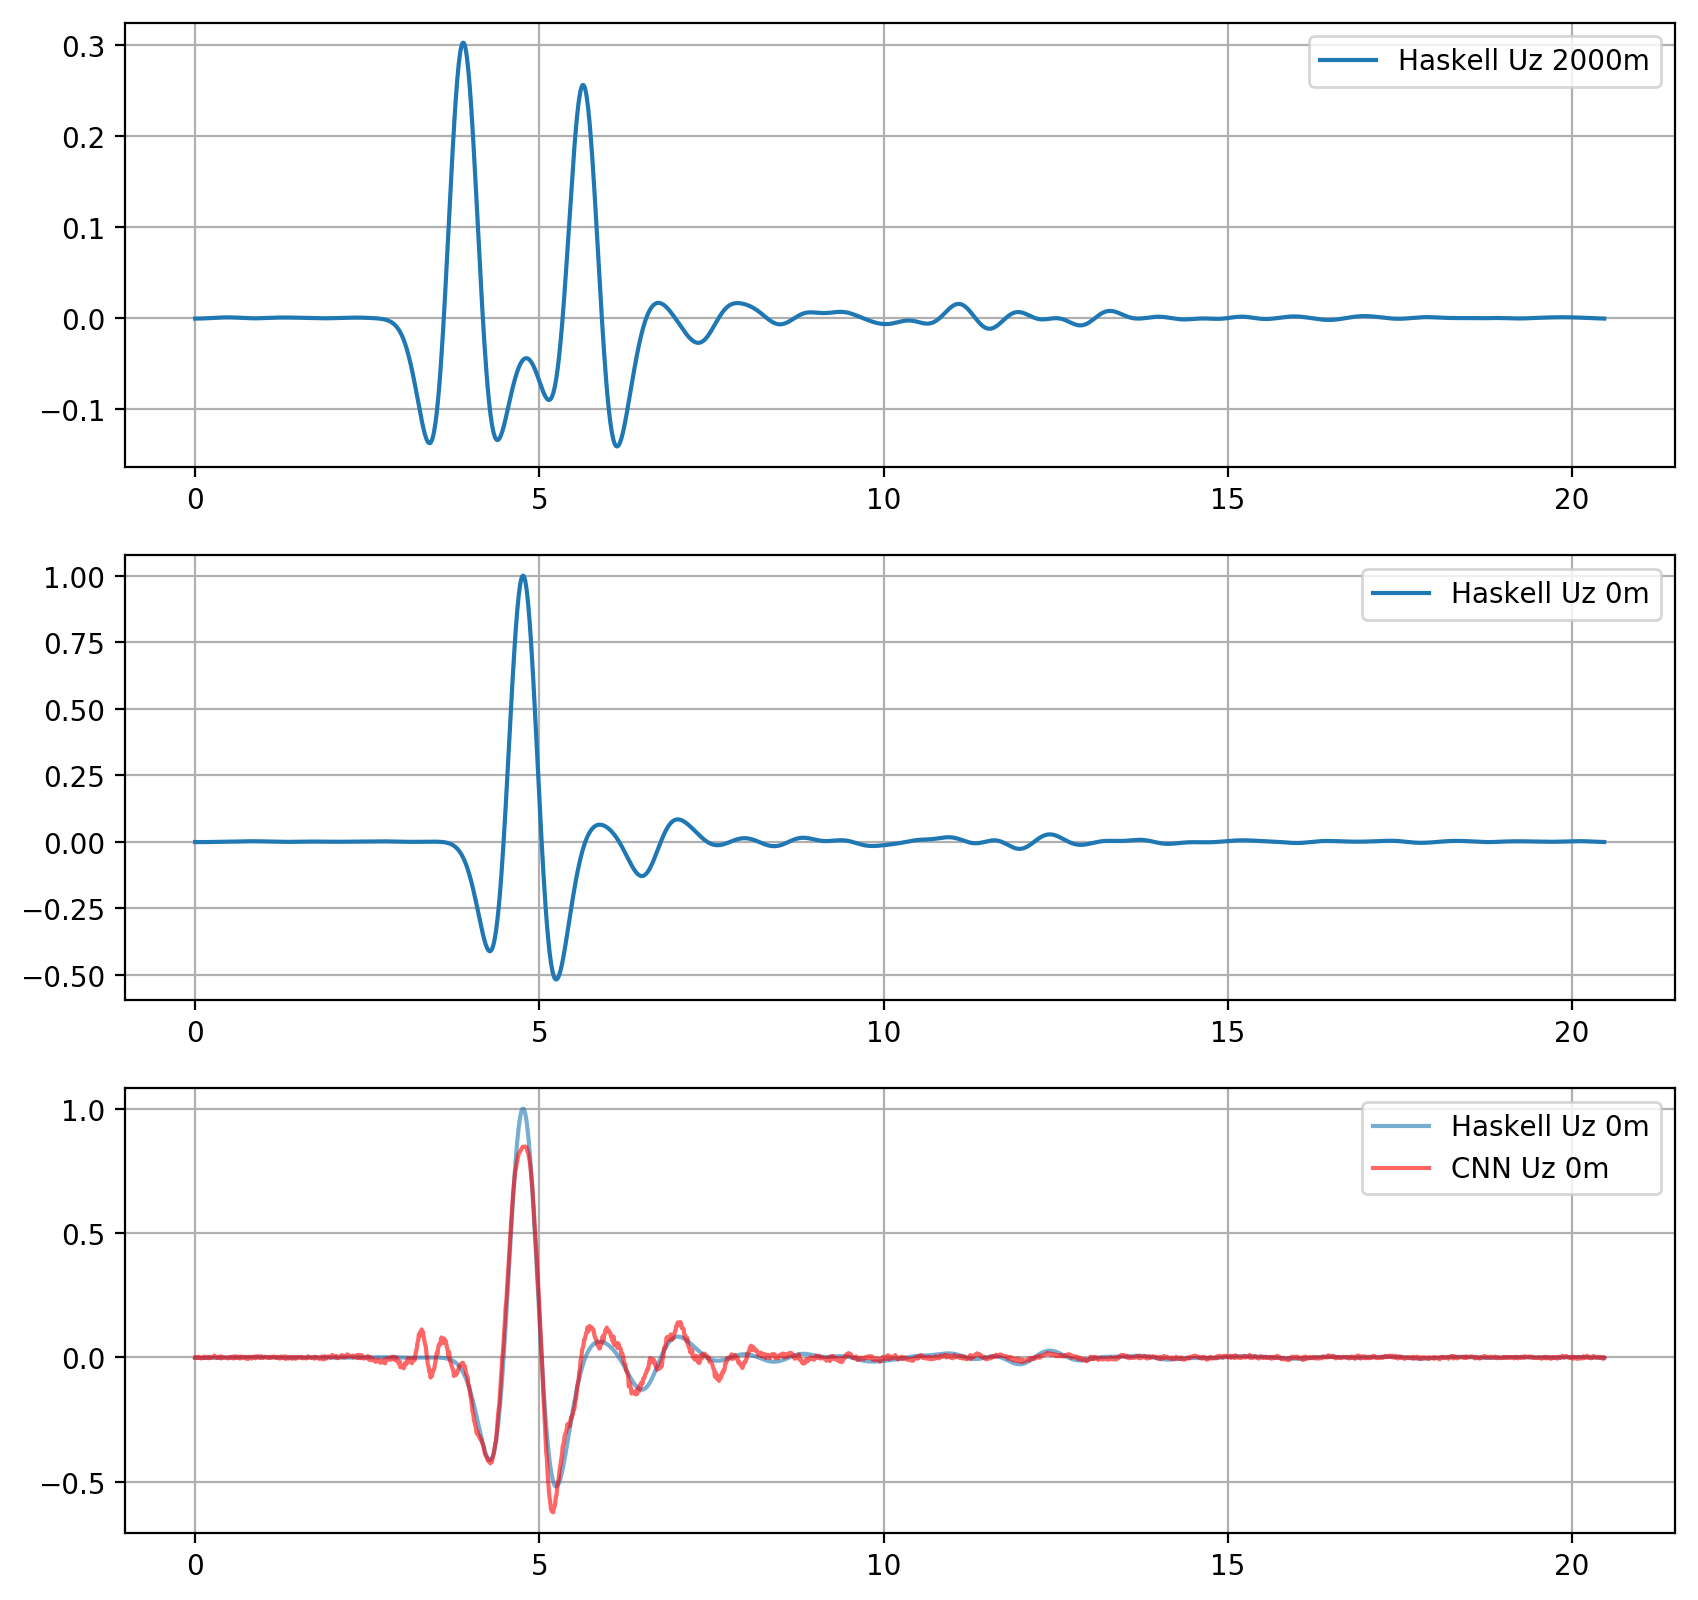

In [277]:
#予測
n=1000
prediction_n=simple_CNN.predict(X_train[0:n])

i=80
prediction=prediction_n[i]

plt.figure(figsize=(10, 10),dpi=200)

plt.subplot(3,1,1)
plt.plot(t,X_train[i],label='Haskell Uz 2000m')
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.plot(t,y_train[i],label='Haskell Uz 0m')
plt.legend()
plt.grid()

plt.subplot(3,1,3)
plt.plot(t,y_train[i],alpha=0.6,label='Haskell Uz 0m')
plt.plot(t,prediction,alpha=0.6,color='red',label='CNN Uz 0m')
plt.legend()
plt.grid()